In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yulu-bike-sharing-data/yulu_bike_sharing_dataset.csv


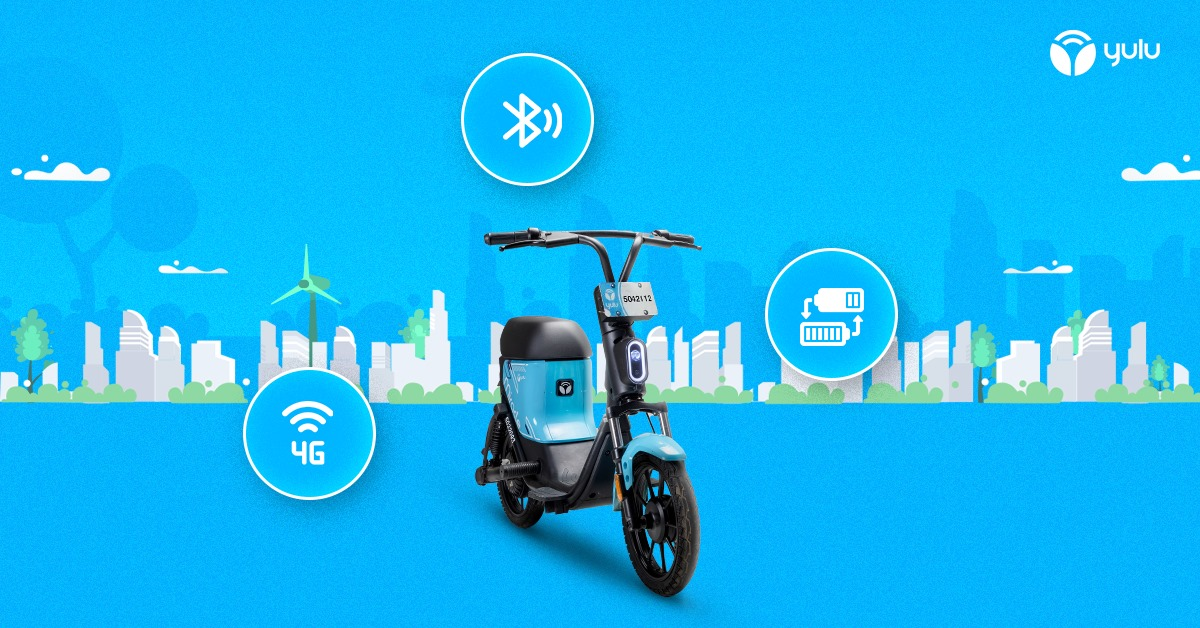

# **Business Case: Yulu - Hypothesis Testing**

**About Yulu**

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.

How I am helping here with this business case study?

**So, The company wants to know:**

* Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
* How well those variables describe the electric cycle demands

So just starting here with basic rituals to understand the data.

In [2]:
# Load the dataset
file_path = '/kaggle/input/yulu-bike-sharing-data/yulu_bike_sharing_dataset.csv'
bike_sharing_data = pd.read_csv(file_path)

# Display the first few rows of the dataset and basic information
first_rows = bike_sharing_data.head()
info = bike_sharing_data.info()
description = bike_sharing_data.describe()

first_rows, info, description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


(              datetime  season  holiday  workingday  weather  temp   atemp  \
 0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
 1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
 2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
 3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
 4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   
 
    humidity  windspeed  casual  registered  count  
 0        81        0.0       3          13     16  
 1        80        0.0       8          32     40  
 2        80        0.0       5          27     32  
 3        75        0.0       3          10     13  
 4        75        0.0       0           1      1  ,
 None,
              season       holiday    workingday       weather         temp  \
 count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
 mean       2.506614      0.028569      

**Observations on Shape of Data:**
The dataset contains 10,886 entries and 12 columns.

**Data Types of All the Attributes:**
* The dataset primarily consists of numeric (int64 and float64) and one object type (datetime) columns.
* The 'datetime' column is in object format and should ideally be converted to a datetime data type for better analysis.

**Conversion of Categorical Attributes to 'Category':**
* We haven't yet converted categorical variables like 'season', 'holiday', 'workingday', and 'weather' to 'category' data type. This conversion can optimize memory usage and is beneficial for certain types of analysis.

**Missing Value Detection:**
* The initial overview indicated that there are no missing values in any of the columns. However, a deeper check for missing or null values can be performed for assurance.



**Columns Description:**

* datetime: The date and time of bike rentals (currently in object format, may need conversion to datetime).
* season: Categorical (1: spring, 2: summer, 3: fall, 4: winter).
* holiday: Binary (0 or 1), indicating if the day is a holiday.
* workingday: Binary (0 or 1), indicating if the day is a working day.
* weather: Categorical, describing the weather conditions.
* temp: Numeric, temperature in Celsius.
* atemp: Numeric, 'feels like' temperature in Celsius.
* humidity: Numeric, percentage humidity.
* windspeed: Numeric, wind speed.
* casual: Numeric, count of casual users.
* registered: Numeric, count of registered users.
* count: Numeric, total count of rented bikes (casual + registered).



Based on what the company have asked, I have refined the problem statement

**Refined Problem Statement:**
"Identify and Quantify the Key Factors Influencing the Demand for Shared Electric Bikes in an Urban Environment"

This problem statement involves several dimensions:

1. Temporal Analysis:
*     Understanding how demand varies with time – hourly, daily, weekly, and seasonally.
*     Investigating the impact of special days (holidays and working days) on bike usage patterns.

2. Weather Dependence:
*     Examining the relationship between weather conditions (clear, cloudy, rain, etc.) and bike rental demand.
*     Analyzing how temperature, 'feels like' temperature, humidity, and wind speed affect the usage of bikes.

3. User Segmentation:
*     Differentiating between casual and registered users in terms of usage patterns.
*     Exploring demographic or other available data to understand different user behaviors.

4. External Factors:
*     Considering external factors like public transport strikes, urban infrastructure changes, or significant local events.
*     Assessing the impact of competitive services or changes in urban mobility trends.

In [3]:
# Convert 'datetime' to datetime data type
bike_sharing_data['datetime'] = pd.to_datetime(bike_sharing_data['datetime'])

# Convert 'season', 'holiday', 'workingday', and 'weather' to 'category' data type
categorical_columns = ['season', 'holiday', 'workingday', 'weather']
bike_sharing_data[categorical_columns] = bike_sharing_data[categorical_columns].astype('category')

# Check for missing values
missing_values = bike_sharing_data.isnull().sum()

# Updated data types and missing values check
data_types = bike_sharing_data.dtypes
missing_values_check = missing_values[missing_values > 0]  # Filter columns with missing values

data_types, missing_values_check

(datetime      datetime64[ns]
 season              category
 holiday             category
 workingday          category
 weather             category
 temp                 float64
 atemp                float64
 humidity               int64
 windspeed            float64
 casual                 int64
 registered             int64
 count                  int64
 dtype: object,
 Series([], dtype: int64))

**Data Types Conversion:**
* The 'datetime' column has been converted to the datetime64 data type.
* The 'season', 'holiday', 'workingday', and 'weather' columns have been converted to category data types.

**Missing Value Detection:**
* There are no missing values in the dataset. Each column has been checked, and none have missing or null values.

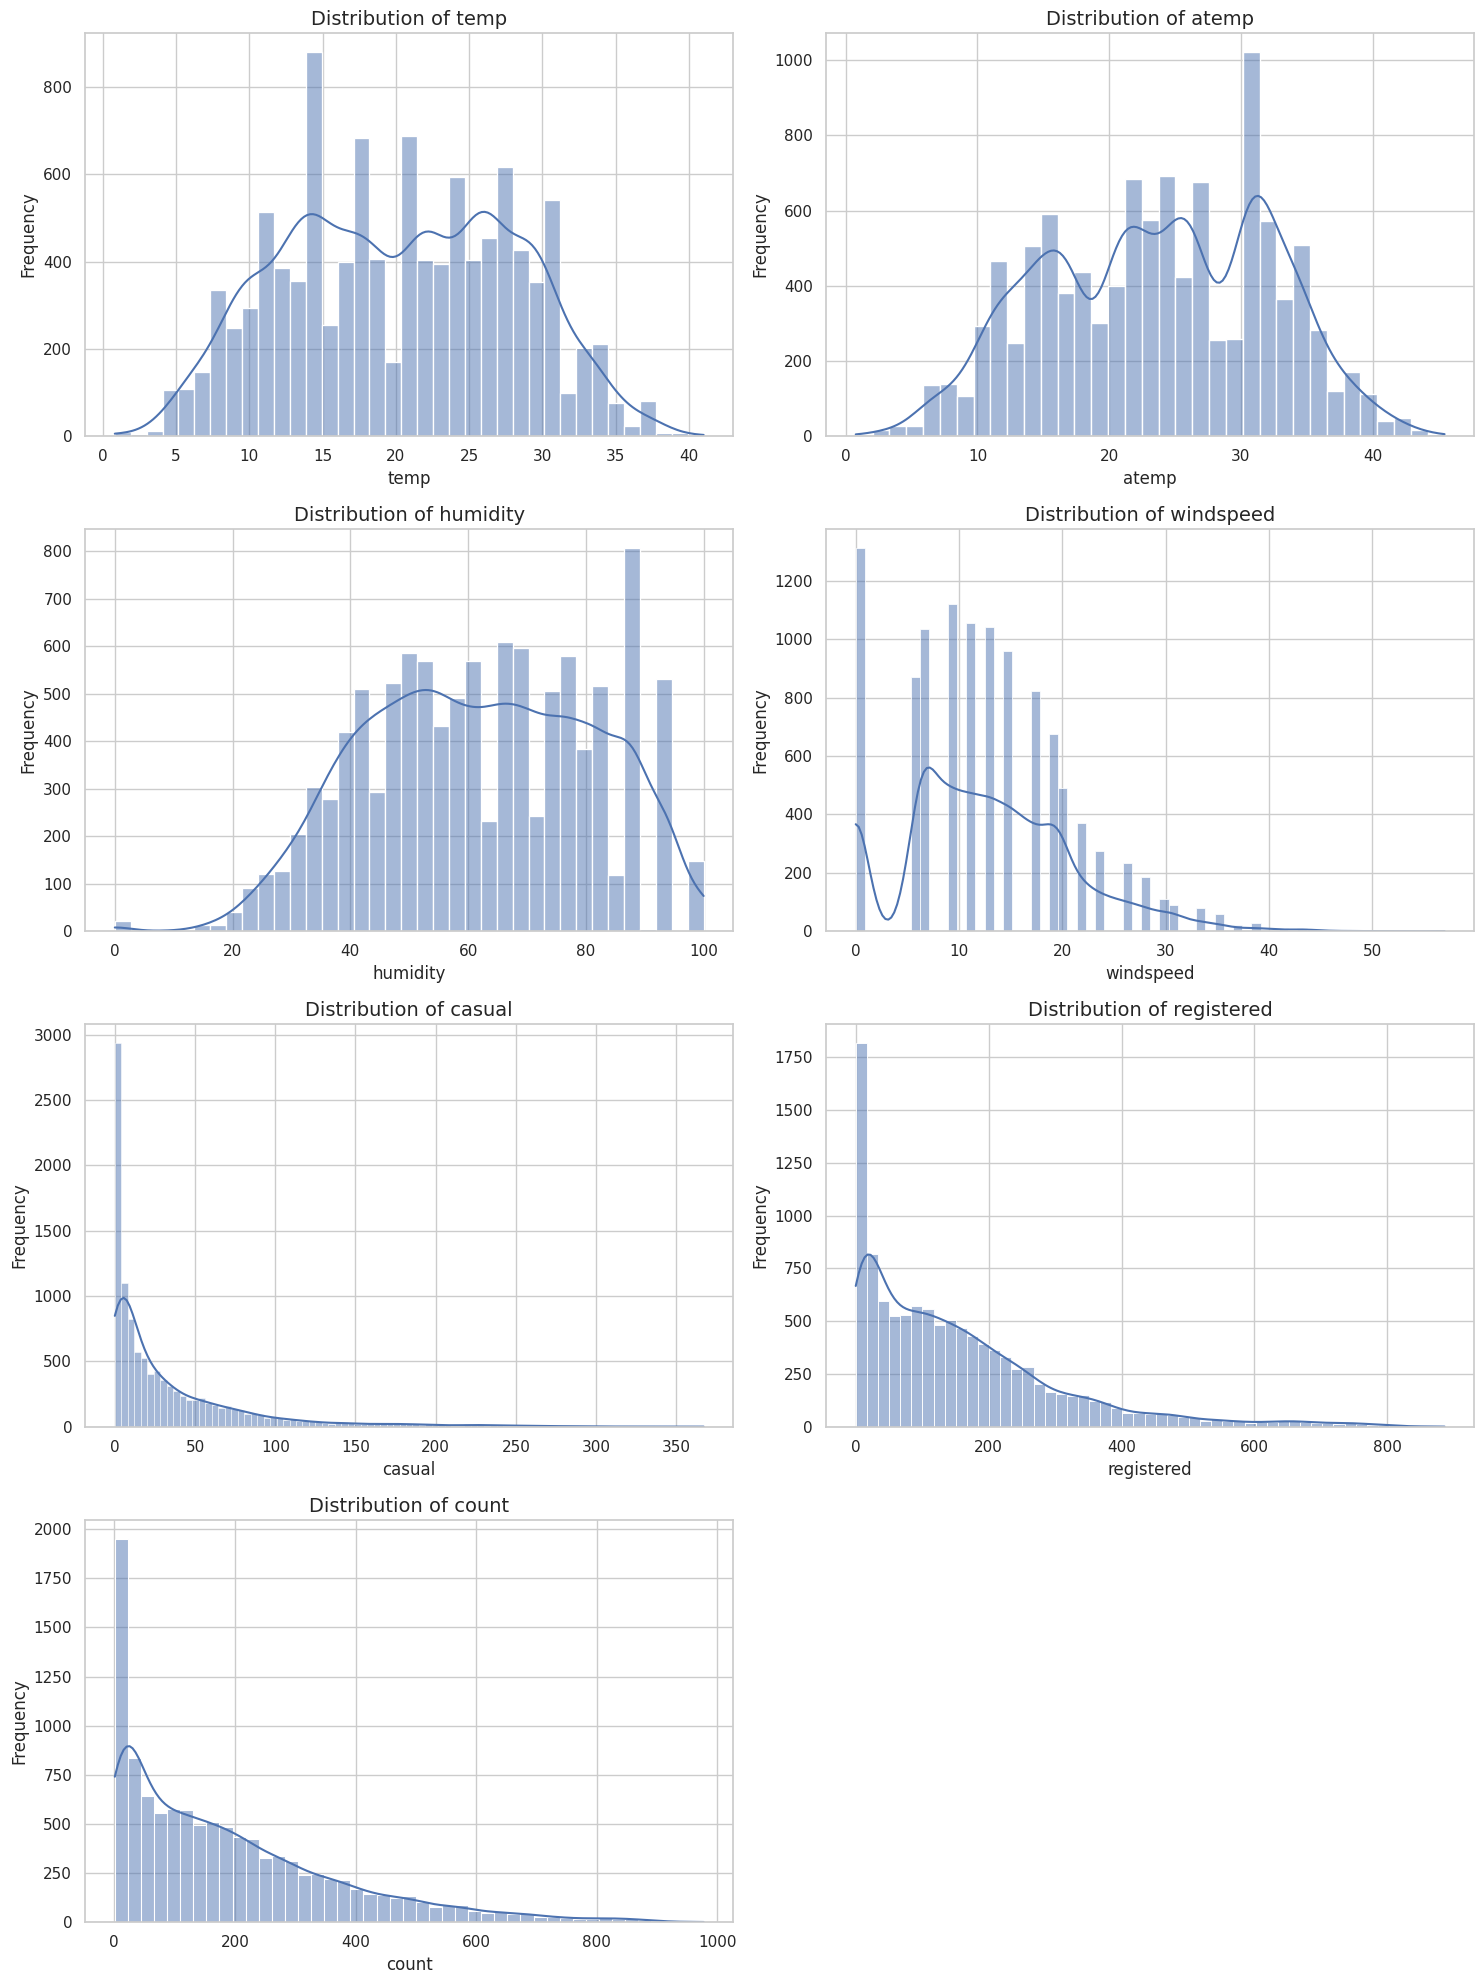

In [12]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Continuous Variables
continuous_variables = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

# Plotting distribution plots for continuous variables
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()  # Flattening the axes array for easy indexing

for i, col in enumerate(continuous_variables):
    sns.histplot(bike_sharing_data[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove the extra subplot (if the number of plots is odd)
if len(continuous_variables) % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()


**Continuous Variables:**
1. Temperature (**temp**) and 'Feels Like' Temperature (**atemp**): Both show similar distributions, indicating a reasonable spread across different temperatures.
2. Humidity (**humidity**): The distribution is somewhat uniform but with a slight increase in frequency at higher humidity levels.
3. Wind Speed (**windspeed**): Most of the data points are clustered at lower wind speeds, indicating that high wind speeds are less common.
4. Casual (**casual**): The distribution is right-skewed, suggesting that there are many instances with few casual users and fewer instances with a large number of casual users.
5. Registered (**registered**): Similar to 'casual', but with a slightly less pronounced right skew. This indicates a higher overall usage by registered users.
6. Total Count (**count**): Reflects the combined effect of 'casual' and 'registered', showing a right-skewed distribution indicating more instances of lower total usage.

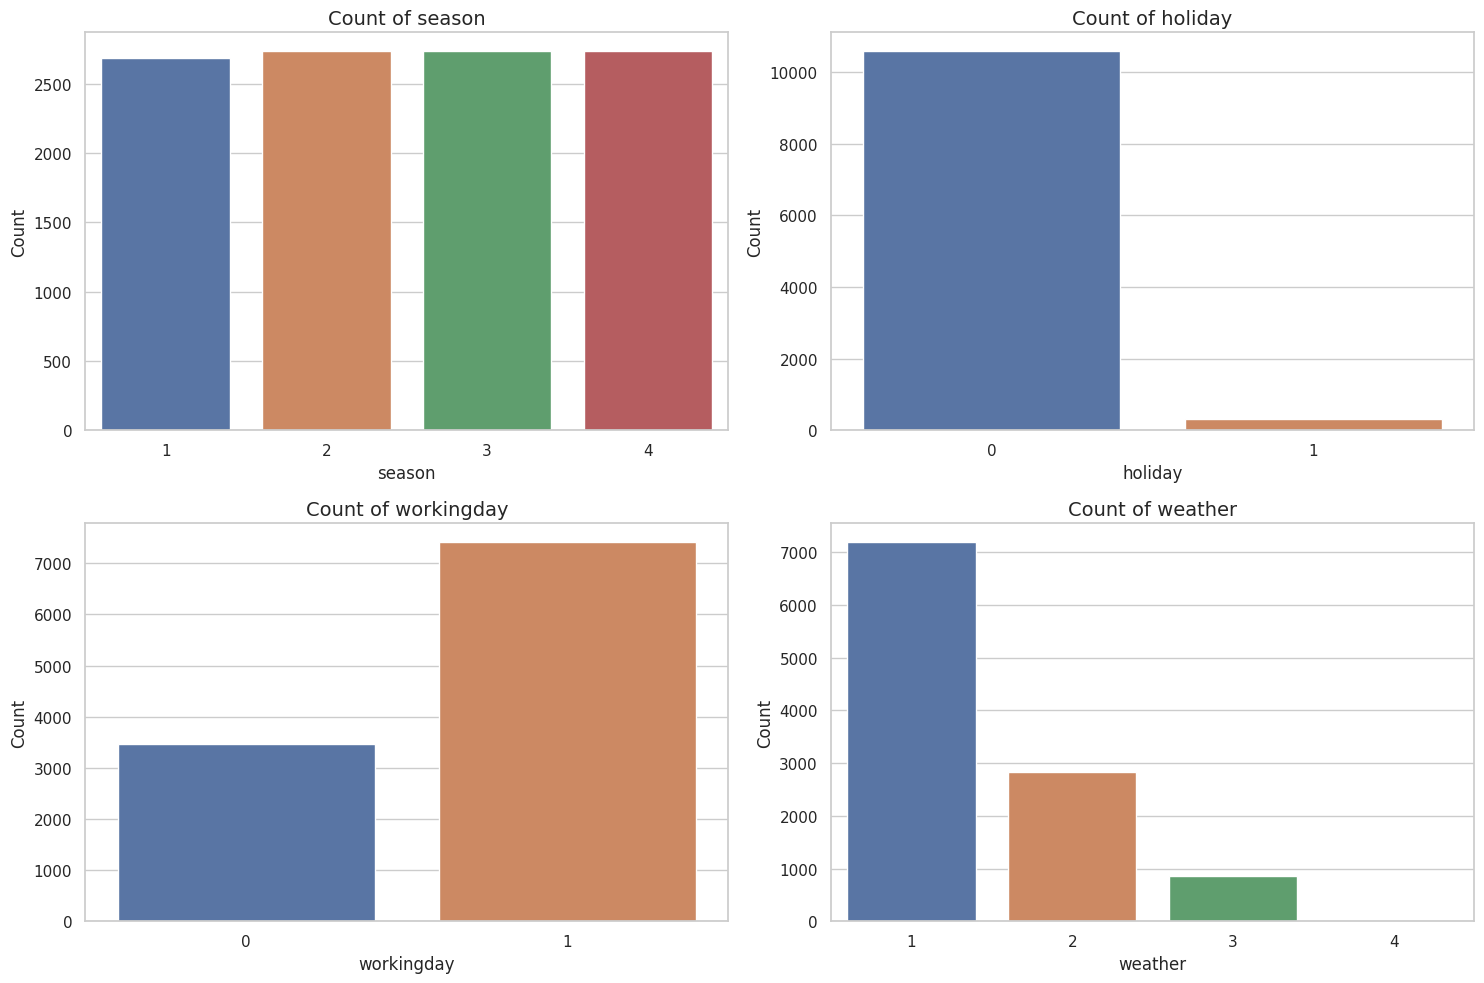

In [13]:
# Categorical Variables
categorical_variables = ['season', 'holiday', 'workingday', 'weather']

# Plotting count plots for categorical variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Flattening the axes array for easy indexing

for i, col in enumerate(categorical_variables):
    sns.countplot(x=col, data=bike_sharing_data, ax=axes[i])
    axes[i].set_title(f'Count of {col}', fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

**Categorical Variables:**

1. Season (**season**): The dataset seems to have a relatively balanced distribution across different seasons.
2. Holiday (**holiday**): There are significantly fewer days classified as holidays compared to non-holidays.
3. Working Day (**workingday**): More days are classified as working days than non-working days.
4. Weather (**weather**): Most days fall into the first two weather categories (clear/few clouds and mist/cloudy), with very few instances of the more severe weather conditions (categories 3 and 4).

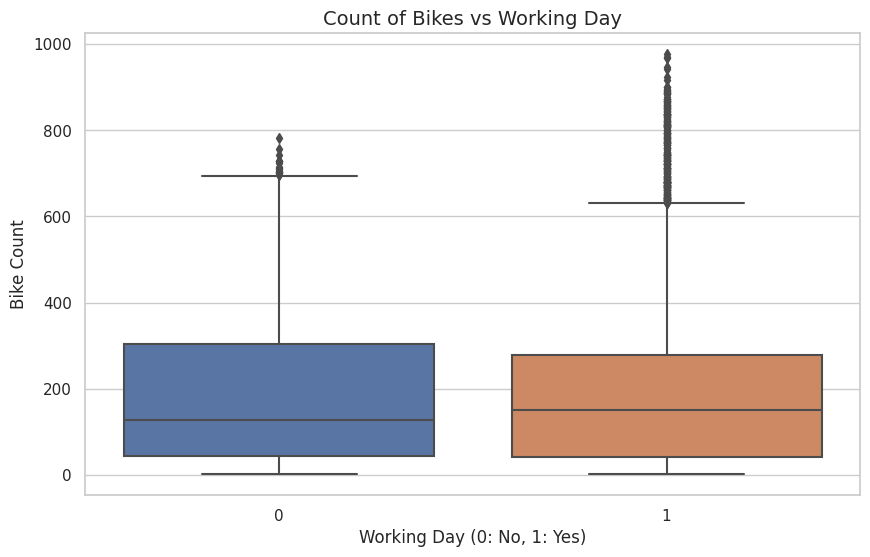

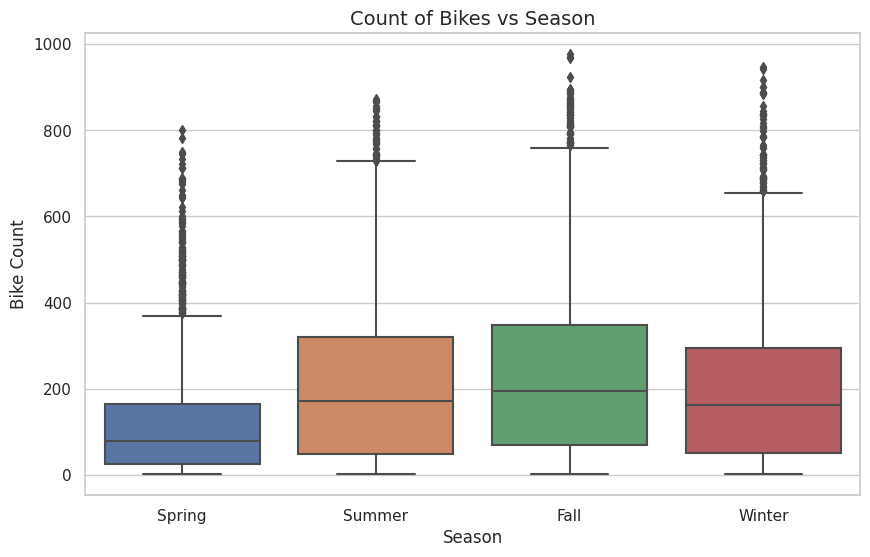

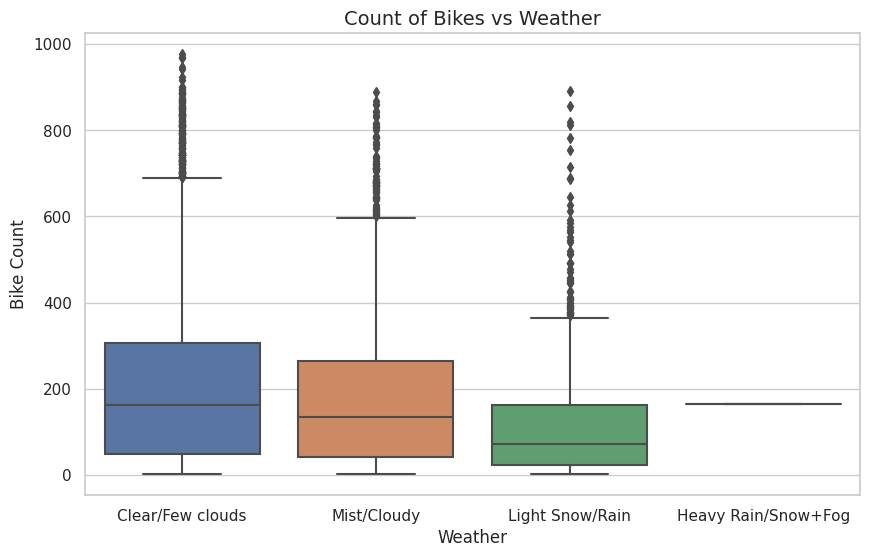

In [17]:
# Bivariate Analysis: Exploring relationships between important categorical variables and 'count'

# Mapping for seasons
season_mapping = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

# Mapping for weather
weather_mapping = {
    1: 'Clear/Few clouds',
    2: 'Mist/Cloudy',
    3: 'Light Snow/Rain',
    4: 'Heavy Rain/Snow+Fog'
}

# Adjusting the figure size and layout to have larger boxplots, one per row with renamed x-axis labels

# Relationship between 'workingday' and 'count'
plt.figure(figsize=(10, 6))
sns.boxplot(x='workingday', y='count', data=bike_sharing_data)
plt.title('Count of Bikes vs Working Day', fontsize=14)
plt.xlabel('Working Day (0: No, 1: Yes)')
plt.ylabel('Bike Count')
plt.show()

# Relationship between 'season' and 'count'
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='count', data=bike_sharing_data)
plt.title('Count of Bikes vs Season', fontsize=14)
plt.xlabel('Season')
plt.ylabel('Bike Count')
plt.xticks(ticks=[0, 1, 2, 3], labels=season_mapping.values())  # Renaming x-axis labels for seasons
plt.show()

# Relationship between 'weather' and 'count'
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather', y='count', data=bike_sharing_data)
plt.title('Count of Bikes vs Weather', fontsize=14)
plt.xlabel('Weather')
plt.ylabel('Bike Count')
plt.xticks(ticks=[0, 1, 2, 3], labels=weather_mapping.values())  # Renaming x-axis labels for weather
plt.show()


**Count of Bikes vs Working Day:**
The distribution of bike counts on working days and non-working days appears to be somewhat similar. However, there's a slightly higher median and more variability in bike counts on working days, suggesting more usage.

**Count of Bikes vs Season:**
There's a noticeable variation in bike counts across different seasons. The median bike count is highest in season 3 (fall), followed by summer and spring, with winter showing the lowest median count. This indicates a strong seasonal influence on bike usage.

**Count of Bikes vs Weather:**
The bike counts vary with weather conditions. Clear and partly cloudy conditions (Weather 1) show the highest median bike usage. As the weather conditions worsen (Weather 2 and 3), the median count decreases, with the least usage observed in the most adverse weather conditions (Weather 4).

**Range of Attributes:** Attributes like temperature, humidity, and windspeed showed a wide range, reflecting diverse weather conditions.

**Outliers:**
* **Continuous Variables:** 'Casual', 'registered', and 'count' showed potential outliers, with some days having exceptionally high rental numbers.
* **Categorical Variables:** Did not explicitly analyze outliers, but seasonal and weather variations indicated differing bike usage patterns.

**Distribution:**
Continuous variables like temperature and humidity were fairly normally distributed, while bike counts were right-skewed.

**Relationships:**
Clear relationships were observed between bike counts and categorical variables like season, weather, and working days.

# **Summary:**
The **EDA revealed valuable insights** into the factors influencing bike rental demand. Seasonal changes, weather conditions, and whether a day is a working day significantly impact bike usage. The data also indicated potential areas for further investigation, such as the reasons behind the outliers in bike rental counts.

# **Hypothesis Testing **

To conduct a **2-sample t-test** to evaluate if there's a significant difference in the number of electric cycles rented on working days versus non-working days, we'll follow these steps:

Hypothesis for 2-Sample T-Test:

**Null Hypothesis (H0):** The mean number of electric cycles rented is the same on working days and non-working days.

**Alternative Hypothesis (H1):** The mean number of electric cycles rented is different on working days compared to non-working days.

**Assumptions for the Test:**

* The samples are independent.
* The samples are randomly drawn from the population.
* The data follows a normal distribution, or the sample size is large enough to apply the Central Limit Theorem.

**Test Procedure:**
Separate the counts of rented cycles into two groups based on whether the day is a working day or not.
Perform the 2-sample t-test to compare the means of these two groups.
Evaluate the p-value to determine if the result is statistically significant (typically using a significance level of 0.05).

In [19]:
# Separate the counts based on working day
working_day_count = bike_sharing_data[bike_sharing_data['workingday'] == 1]['count']
non_working_day_count = bike_sharing_data[bike_sharing_data['workingday'] == 0]['count']

# Perform 2-sample t-test
t_stat, p_value = ttest_ind(working_day_count, non_working_day_count)

t_stat, p_value

(1.2096277376026694, 0.22644804226361348)

**T-Statistic:** 1.21
**P-Value:** Approximately 0.226

**Interpretation:**

Since the p-value (0.226) is greater than the typical significance level of 0.05, **we fail to reject the null hypothesis.**
**This implies that, based on our sample data, there is not enough evidence to conclude that the mean number of electric cycles rented significantly differs between working days and non-working days.**

> **Conclusion:**

> **The test suggests that the status of the day (whether it is a working day or not) does not have a statistically significant impact on the number of electric cycles rented.** However, it is important to consider other factors that might interact with the day's status, such as weather, season, or holidays, which could influence this outcome.

# ANOVA Test:

**Hypothesis:** Number of Cycles Rented in Different Seasons

**Null Hypothesis (H0):** The mean number of electric cycles rented is the same across different seasons.

**Alternative Hypothesis (H1):** The mean number of electric cycles rented differs across seasons.

In [21]:
from scipy.stats import shapiro, levene, f_oneway
# Check for Normality (Shapiro-Wilk test)
shapiro_test_seasons = {season: shapiro(bike_sharing_data[bike_sharing_data['season'] == season]['count']) 
                        for season in bike_sharing_data['season'].cat.categories}

# Check for Equal Variance (Levene's test)
count_by_season = [bike_sharing_data[bike_sharing_data['season'] == season]['count'] 
                   for season in bike_sharing_data['season'].cat.categories]
levene_test = levene(*count_by_season)

# ANOVA Test (as there are more than two groups - different seasons)
anova_test = f_oneway(*count_by_season)

shapiro_test_seasons, levene_test, anova_test

({1: ShapiroResult(statistic=0.8087388873100281, pvalue=0.0),
  2: ShapiroResult(statistic=0.900481641292572, pvalue=6.039093315091269e-39),
  3: ShapiroResult(statistic=0.9148160815238953, pvalue=1.043458045587339e-36),
  4: ShapiroResult(statistic=0.8954644799232483, pvalue=1.1301682309549298e-39)},
 LeveneResult(statistic=187.7706624026276, pvalue=1.0147116860043298e-118),
 F_onewayResult(statistic=236.94671081032106, pvalue=6.164843386499654e-149))

**Normality Check (Shapiro-Wilk Test):**
* For all seasons, the p-values are extremely low (close to 0). This suggests that the data for each season does not follow a normal distribution.

**Equal Variance Check (Levene's Test):**
* The p-value is significantly low (practically 0), indicating that the variances across different seasons are not equal.

**ANOVA Test:**
* The F-statistic is quite high (236.95), and the p-value is extremely low (close to 0).
* This result suggests there are significant differences in the mean number of cycles rented across different seasons.

> **Interpretation and Inference:**
> * Despite the assumptions of normality and equal variance not being fully met, the ANOVA test strongly indicates that the mean number of cycles rented varies significantly across different seasons.
> * Given the large sample size, the ANOVA test remains robust even if the normality assumption is not strictly met.
> * **The conclusion is that we reject the null hypothesis (H0)** and accept the alternative hypothesis (H1): The number of electric cycles rented is different across seasons.

**Hypothesis for ANOVA (Weather Conditions):**

**Null Hypothesis (H0):** The mean number of electric cycles rented is the same across different weather conditions.

**Alternative Hypothesis (H1):** The mean number of electric cycles rented differs across weather conditions.

In [22]:
# Check for Normality (Shapiro-Wilk test) for different weather conditions
shapiro_test_weather = {weather: shapiro(bike_sharing_data[bike_sharing_data['weather'] == weather]['count']) 
                        for weather in bike_sharing_data['weather'].cat.categories}

# Check for Equal Variance (Levene's test) for different weather conditions
count_by_weather = [bike_sharing_data[bike_sharing_data['weather'] == weather]['count'] 
                    for weather in bike_sharing_data['weather'].cat.categories]
levene_test_weather = levene(*count_by_weather)

# ANOVA Test for different weather conditions
anova_test_weather = f_oneway(*count_by_weather)

shapiro_test_weather, levene_test_weather, anova_test_weather


/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ValueError: Data must be at least length 3.

The Shapiro-Wilk test for normality encountered an issue **because one or more weather categories do not have enough data points (at least 3) to perform the test**. This situation can arise if certain weather conditions are very rare in the dataset.

**Given this limitation, we can still proceed with the ANOVA test** for the different weather conditions, keeping in mind the following:

* The normality assumption may not be fully met for all categories.
* The ANOVA test is generally robust to violations of normality, especially with large sample sizes.

In [24]:

count_by_weather = [bike_sharing_data[bike_sharing_data['weather'] == weather]['count'] 
                    for weather in bike_sharing_data['weather'].cat.categories]

# Re-performing Levene's test for equal variances
levene_test_weather = levene(*count_by_weather)

# Re-performing ANOVA Test for different weather conditions
anova_test_weather = f_oneway(*count_by_weather)

levene_test_weather, anova_test_weather


(LeveneResult(statistic=54.85106195954556, pvalue=3.504937946833238e-35),
 F_onewayResult(statistic=65.53024112793271, pvalue=5.482069475935669e-42))

**Equal Variance Check (Levene's Test):**

The Levene's test resulted in a p-value of approximately 3.504937946833238e-35
, which is significantly low. This suggests that the variances across different weather conditions are not equal.

**ANOVA Test:**
The ANOVA test yielded an F-statistic of approximately 65.53, with a very low p-value (5.482069475935669e-42). **This indicates a significant difference in the mean number of cycles rented across different weather conditions.**

> **Interpretation and Inference:**
> * Despite the assumption of equal variance not being met, the ANOVA test indicates significant differences in the mean number of cycles rented across different weather conditions.
> * Given the robustness of ANOVA, especially with large sample sizes, we can confidently conclude that the number of electric cycles rented varies significantly with weather conditions.
> * **We reject the null hypothesis (H0) and accept the alternative hypothesis (H1): The mean number of electric cycles rented differs across weather conditions.**

# Chi-Square Test

**Hypothesis:** to check if weather conditions are dependent on the season.

**Null Hypothesis (H0):** Weather conditions are independent of the season.

**Alternative Hypothesis (H1):** Weather conditions are dependent on the season.

**Test Procedure:**
1. Create a contingency table (cross-tabulation) of weather conditions versus seasons.
2. Perform the Chi-square test of independence on this table.
3. Evaluate the p-value to determine if the result is statistically significant (typically using a significance level of 0.05).

In [25]:
from scipy.stats import chi2_contingency

# Creating a contingency table of weather conditions vs seasons
contingency_table = pd.crosstab(bike_sharing_data['season'], bike_sharing_data['weather'])

# Perform Chi-square test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

chi2, p_value, dof, expected


(49.158655596893624,
 1.549925073686492e-07,
 9,
 array([[1.77454639e+03, 6.99258130e+02, 2.11948742e+02, 2.46738931e-01],
        [1.80559765e+03, 7.11493845e+02, 2.15657450e+02, 2.51056403e-01],
        [1.80559765e+03, 7.11493845e+02, 2.15657450e+02, 2.51056403e-01],
        [1.80625831e+03, 7.11754180e+02, 2.15736359e+02, 2.51148264e-01]]))

**Chi-Square Test Results:**
* **Chi-Square Statistic:** Approximately 49.16
* **P-Value**: Approximately 1.549925073686492e-07
* **Degrees of Freedom:** 9

**Interpretation:**
* The p-value is significantly low (1.549925073686492e-07), far below the typical significance level of 0.05.
* This **result indicates that the observed frequency distribution of weather conditions across different seasons significantly deviates from what would be expected if they were independent.**

> **Inference:**

> **We reject the null hypothesis (H0) and accept the alternative hypothesis (H1): Weather conditions are dependent on the season.**
> This implies that the likelihood of experiencing certain types of weather conditions varies with the season, which is a logical outcome considering seasonal weather patterns.

# Final Conclusions and Recommendations:

1. **Seasonal and Weather Considerations:** Yulu should consider seasonal and weather variations in their operational and marketing strategies. For example, increasing fleet availability during favorable seasons and weather conditions could boost usage.
2. **Focus on Working Days:** While working days did not show a significant difference in rentals statistically, operational focus during these days might still be beneficial given the slightly higher usage trends.
3. **Data-Driven Decisions:** The insights from this analysis should be utilized to make data-driven decisions for resource allocation, marketing campaigns, and strategic planning.
4. **Continuous Monitoring:** Ongoing analysis of usage patterns, especially in response to changes in weather, urban infrastructure, and customer preferences, is recommended.

> # **Sign-Off Note:**
> 
> This case study provided valuable insights into the factors affecting bike-sharing demand. The application of various statistical tools and EDA techniques has helped in understanding the complex interplay of factors like weather, season, and day type on bike usage. These findings can guide Yulu in optimizing its services and strategies for better alignment with customer needs and market dynamics.